In [9]:
import wave as _wave
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy
import IPython
import math
import os

duepi=np.sqrt(2*3.1415)

def gauss(x,mu, sigma):
    return np.exp(-(x-mu)**2/(sigma*sigma))/(sigma*sigma*duepi)




def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a WAV file.

    Parameters
    ----------
    file : string or file object
        Either the name of a file or an open file pointer.

    Return Values
    -------------
    rate : float
        The sampling frequency (i.e. frame rate)
    sampwidth : float
        The sample width, in bytes.  E.g. for a 24 bit WAV file,
        sampwidth is 3.
    data : numpy array
        The array containing the data.  The shape of the array is
        (num_samples, num_channels).  num_channels is the number of
        audio channels (1 for mono, 2 for stereo).

    Notes
    -----
    This function uses the `wave` module of the Python standard libary
    to read the WAV file, so it has the same limitations as that library.
    In particular, the function does not read compressed WAV files.

    """
    wav = _wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, array


def writewav24(filename, rate, data):
    """
    Create a 24 bit wav file.

    Parameters
    ----------
    filename : string
        Name of the file to create.
    rate : float
        The sampling frequency (i.e. frame rate) of the data.
    data : array-like collection of integer or floating point values
        data must be "array-like", either 1- or 2-dimensional.  If it
        is 2-d, the rows are the frames (i.e. samples) and the columns
        are the channels.

    Notes
    -----
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.

    Example
    -------
    Create a 3 second 440 Hz sine wave.

    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)

    """
    a32 = np.asarray(data, dtype=np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> np.array([0, 8, 16])) & 255
    wavdata = a8.astype(np.uint8).tostring()

    w = _wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

In [10]:
attacco = 50000
fine = 300000
durata = fine-attacco

In [11]:
path = "Organ/note_30.wav"
data_tot=np.array([])
for i in range(1,150):
    path=f"Organ/note_{i}.wav"
    rate, data = readwav(path)
    # data_tot=np.append(data_tot,data[attacco:fine,0])
path=f"Organ/note_15.wav"
rate, data = readwav(path)

seconds=durata/rate
    
IPython.display.Audio(data[attacco:2*fine, 0], rate=rate)

<ipython-input-9-1a7e32b1f652>:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_bytes = np.fromstring(data, dtype=np.uint8)


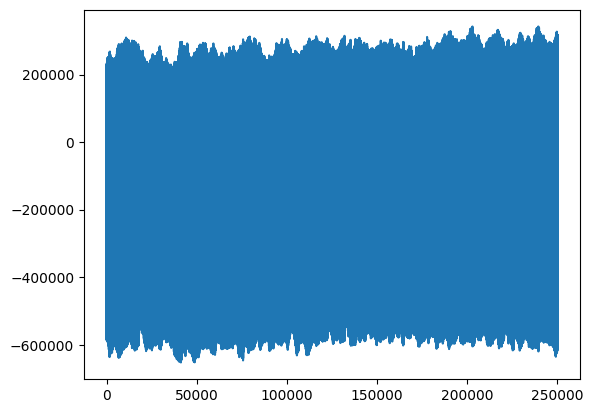

In [12]:
plt.plot(data[attacco:fine, 0])
plt.show()

In [13]:
plt.plot(data[attacco:fine, 0]*gauss(np.linspace(0,durata,durata), (fine-attacco)*0.5,(fine-attacco)*0.05))
plt.plot(np.linspace(0,durata,durata),10000*gauss(np.linspace(0,durata,durata), (fine-attacco)*0.5,(fine-attacco)*0.05))

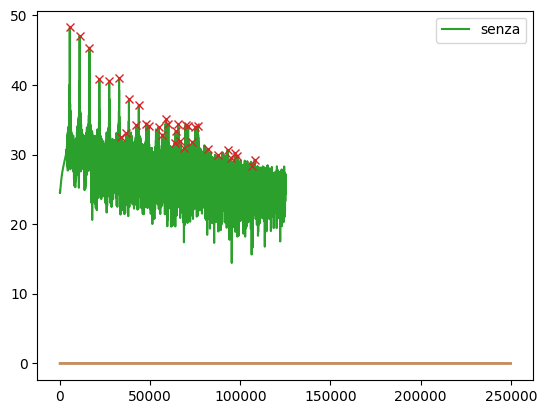

In [14]:
fft_res=scipy.fft.rfft(data[attacco:fine, 0]*gauss(np.linspace(0,durata,durata), (fine-attacco)*0.5,(fine-attacco)*0.05))
fft_res=abs(fft_res)**2

fft_res_noG=scipy.fft.rfft(data[attacco:fine, 0])
fft_res_noG=abs(fft_res_noG)**2

# fft_res=np.log(fft_res)
fft_res_noG=np.log(fft_res_noG)

peaks, _ =scipy.signal.find_peaks(fft_res_noG, prominence=11)

# plt.plot(fft_res,  label="con")

plt.plot(fft_res_noG,label="senza")
plt.plot(peaks, fft_res_noG[peaks], "x")

# plt.yscale('log')

plt.legend()
plt.show()

In [15]:
diffs=[]
for i in range(1,len(peaks)):
    diffs=np.append(diffs, (peaks[i]-peaks[i-1])/seconds)
print(diffs)

[1050.048 1050.24  1050.24  1050.048 1050.24   186.432  584.256  279.36
  779.52   270.144  779.712  270.336 1050.816  402.048  389.952  257.664
  685.056   93.12   271.872  222.336  385.92   169.92   271.872  463.296
  315.648  271.104 1050.048 1050.624 1048.512  360.384  419.712  272.832
 1588.032  239.424]


In [16]:
def most_frequent(arr, toll):
    value=[arr[0]]
    counter =[1]
    check=False
    for i in range(1,len(arr)):
        for k, val in enumerate(value):
            if abs(arr[i]-val)<toll:
                counter[k]+=1
                check=True
        if not check:
            value=np.append(value, arr[i])
            counter=np.append(counter, 1)
        check=False

    # print(value, counter)
    return value[np.argmax(counter)]
        
        

In [17]:
print(most_frequent(diffs, 10))

1050.048


In [18]:
def nota(frequ):
    return math.log2(frequ/440.)*12

In [19]:
nota(most_frequent(diffs, 10))

15.058558191536399

In [20]:
peaks[1]/peaks[0]

2.0

In [21]:
# Build dataset
folder="Organ"
names=[]
for filename in os.listdir(folder):
    f = os.path.join(folder, filename)
        # checking if it is a file
    names=np.append(names, f)

np.random.shuffle(names)
split_point=int(0.8*len(names))
training_names, test_names = names[:split_point], names[split_point:]

def build_dataset_from_names(names, n_rappo):
    dataset=[]
    for n in names:
        rate, data = readwav(n)
        fft_res_noG=scipy.fft.rfft(data[attacco:fine, 0])
        fft_res_noG=abs(fft_res_noG)**2
        fft_res_noG=np.log(fft_res_noG)

        peaks, _ =scipy.signal.find_peaks(fft_res_noG, prominence=11)
        seconds=(fine-attacco)/rate

        diffs=[]
        for i in range(1,len(peaks)):
            diffs=np.append(diffs, (peaks[i]-peaks[i-1]))
        fond=most_frequent(diffs, 10)
        print(fond)
        dato=[]
        for k in range(2,n_rappo+2):
            
            dato=np.append(dato, fft_res_noG[int(k*fond)]/fft_res_noG[int(fond)])
            
            
        dataset=np.append(dataset,dato)
    dataset=np.reshape(dataset,(20,n_rappo) )
        
    return dataset

        
db=(build_dataset_from_names(names[:20],3))

        

        



<ipython-input-9-1a7e32b1f652>:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_bytes = np.fromstring(data, dtype=np.uint8)


1720.0
542.0
682.0
1084.0
4317.0
3441.0
2295.0
912.0
816.0
907.0
2727.0
4868.0
7712.0
767.0
1824.0
2581.0
4095.0
767.0
1366.0
2437.0


In [35]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
print(X,Y,Z)
X, Y, Z = np.split(db, 3, 1)
%matplotlib qt
ax = Axes3D(fig)
ax.scatter(X, Y, Z,c=Z, cmap='Greens')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(10, 50)
plt.show()





[[0.98693782]
 [0.89621653]
 [1.78449364]
 [0.73587898]
 [0.91224563]
 [0.83047142]
 [1.032178  ]
 [0.94556064]
 [0.93656715]
 [1.04175101]
 [1.04509554]
 [0.94166512]
 [1.09775109]
 [0.81899859]
 [0.98072166]
 [0.80452884]
 [0.87214051]
 [0.9407948 ]
 [0.87321529]
 [0.82789255]] [[0.93494994]
 [0.90703428]
 [1.24390457]
 [0.69293551]
 [0.88898448]
 [0.78898809]
 [0.90973502]
 [1.0234484 ]
 [0.91527378]
 [1.04312118]
 [1.07307082]
 [0.88492138]
 [1.02672973]
 [0.78877448]
 [0.9189489 ]
 [0.89276849]
 [0.9173542 ]
 [0.99603614]
 [0.82748831]
 [0.88200471]] [[0.9436063 ]
 [0.80386195]
 [1.72847603]
 [0.76887303]
 [0.86897475]
 [0.73336698]
 [0.87708806]
 [0.91588315]
 [0.87720029]
 [1.0026427 ]
 [0.93459823]
 [0.89024051]
 [0.93148518]
 [0.84149559]
 [0.77321964]
 [0.79346029]
 [0.90886899]
 [0.86139304]
 [0.82015287]
 [0.81816846]]
